In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl
from tqdm import tqdm

import lightkurve as lk
from lightkurve import TessTargetPixelFile, TessLightCurveFile, TessLightCurve

from astropy.table import Table, join, Column

from smukt import *

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.filterwarnings("ignore")


Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = '../data/smear_stars_tic.csv'
data = Table.read(fname,format='csv')

kic2tic = data['ID','KIC']
kic2tic.rename_column('ID','TIC')

test = Table.read('/Users/benjaminpope/code/smearcampaign/data/Kep_magcut9_v2.csv',format='csv')['Name','Kepler_ID','kepmag']
test.rename_column('Kepler_ID','KIC')
kic2tic = join(kic2tic,test,keys='KIC')

In [3]:
kic2tic

TIC,KIC,Name,kepmag
int64,int64,str10,float64
122783509,1572070,HD_182737,7.82
122516484,2156801,HD_183354,6.32
351056971,2715115,HD_183362,6.394
120763239,2970780,HD_177781,7.744
122304707,3337423,HD_181880,7.982
377872490,3455268,HD_185397,6.953
121326612,3838362,HD_179396,8.001
121989114,3946721,HD_181022,6.496
121085912,4042516,V398_Lyr,7.024


In [21]:
failed = []

for tic, kic, name, kepmag in tqdm(kic2tic[2:4]):
    print(tic,kic,name,kepmag)
    meta = {'Name':name,
        'KIC':kic,
        'TIC':tic,
        'Kepmag':kepmag}

    smeardir = '../../smearcampaign/data/release/'
    fname = 'hlsp_kepler_smear_KPLR%d_kep_v1.0.fits' %  kic
    kepler = Table.read(smeardir+fname)
    kepler = kepler[np.isfinite(kepler['FLUX_CORR_8'])]
    kepler = kepler[kepler['QUARTER']!=0]
    search = lk.search_lightcurvefile(tic)
    try:
        lcf = search.download_all()
        lc = lcf.PDCSAP_FLUX.stitch().remove_nans()
        white, mask = lc.flatten().remove_outliers(return_mask=True)
        lc = lc[~mask].normalize()

        ts_kep = kepler['BJD','FLUX_CORR_8','QUARTER']
        even = (ts_kep['QUARTER'] % 2 == 0)

        ts_kep.rename_columns(['BJD','FLUX_CORR_8'],['time','flux'])
        ts_tess = {'time':lc.time,'flux':lc.flux}

        plot_all(ts_kep,ts_tess,even,meta,save_file='plots_%d.png' % kic,
                 formal_name='%s (KIC %d)' %  (name.replace('_',' '),kic))
    except:
        failed.append(kic)
        
print('Failed on',failed)

  0%|          | 0/2 [00:00<?, ?it/s]

351056971 2715115 HD_183362 6.394


 50%|█████     | 1/2 [00:06<00:06,  6.06s/it]

120763239 2970780 HD_177781 7.744


100%|██████████| 2/2 [00:09<00:00,  5.38s/it]

Failed on [2715115, 2970780]


  0%|          | 0/4 [00:00<?, ?it/s]

122783509 1572070 HD_182737 7.82
SearchResult containing 0 data products.


 25%|██▌       | 1/4 [00:05<00:15,  5.30s/it]

122516484 2156801 HD_183354 6.32
SearchResult containing 1 data products.

target_name                     productFilename                     description  distance
----------- ------------------------------------------------------- ------------ --------
  122516484 tess2019198215352-s0014-0000000122516484-0150-s_lc.fits Light curves      0.0


 50%|█████     | 2/4 [00:11<00:11,  5.50s/it]

351056971 2715115 HD_183362 6.394
SearchResult containing 0 data products.


 75%|███████▌  | 3/4 [00:18<00:05,  5.98s/it]

120763239 2970780 HD_177781 7.744
SearchResult containing 0 data products.


100%|██████████| 4/4 [00:32<00:00,  8.48s/it]


Failed on [1572070, 2715115, 2970780]


<Figure size 432x288 with 0 Axes>

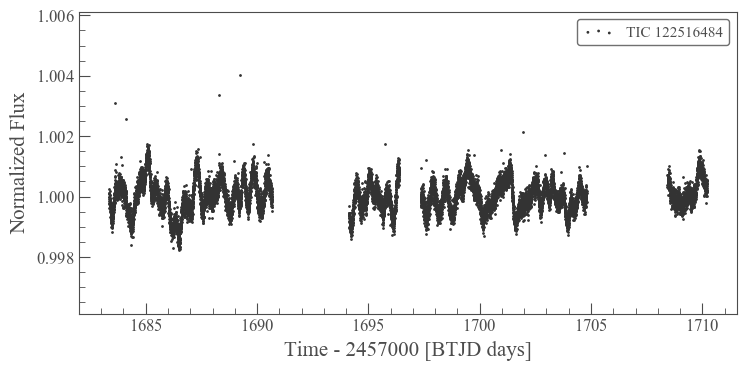

<Figure size 432x288 with 0 Axes>

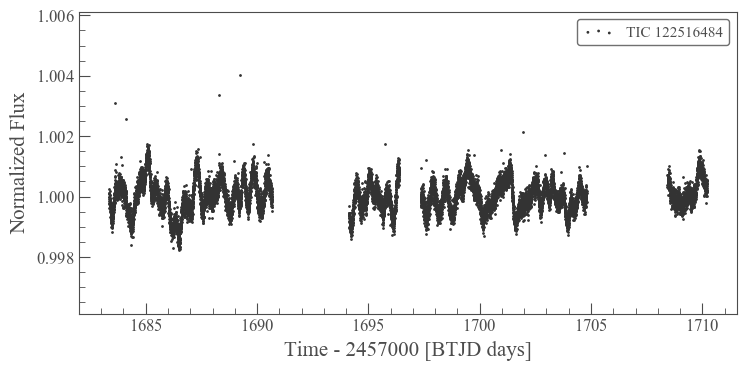

<Figure size 432x288 with 0 Axes>

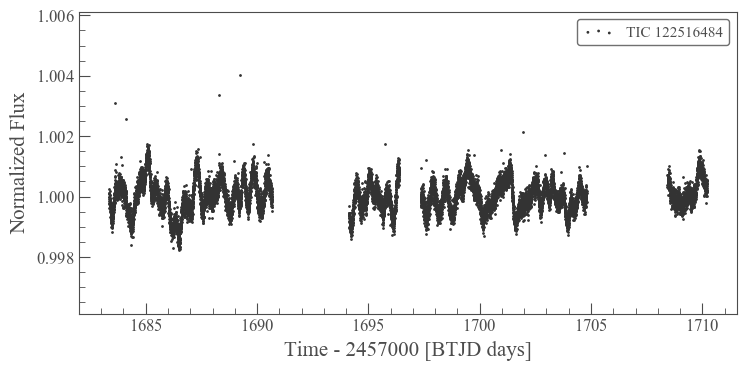

<Figure size 432x288 with 0 Axes>

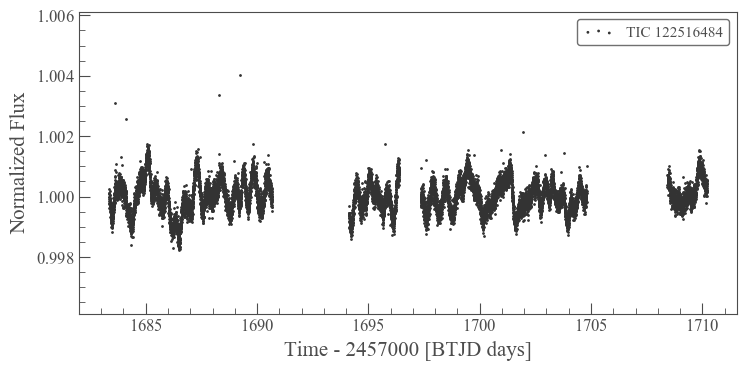

In [28]:
failed = []

for tic, kic, name, kepmag in tqdm(kic2tic[0:4]):
    print(tic,kic,name,kepmag)

    search = lk.search_lightcurvefile(tic)
    print(search)
    fig = plt.figure()
    try:
        lcf = search.download_all()
        lc = lcf.PDCSAP_FLUX.stitch().remove_nans()
    except:
        failed.append(kic)
    lc.scatter()
    fig.savefig('test_%d.png' % kic)
        
print('Failed on',failed)

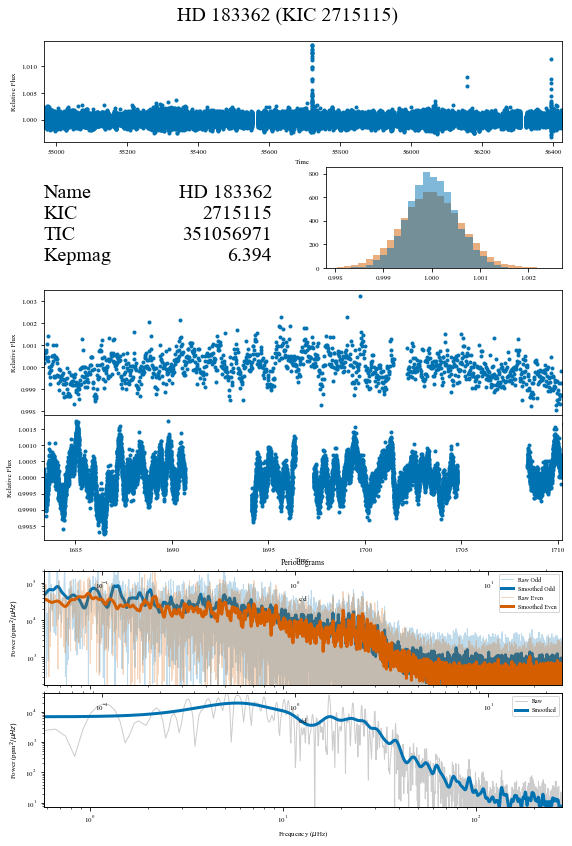

In [5]:
plot_all(ts_kep,ts_tess,even,meta,save_file='plots_%d.png' % kic,
         formal_name='%s (KIC %d)' %  (name.replace('_',' '),kic))


In [27]:
search

SearchResult containing 0 data products.

In [6]:
def plot_hists(ax,data1,data2):
	all_data = np.concatenate((data1,data2))
	low, high = np.percentile(all_data,0.1),np.percentile(all_data,99.9)

	data_1 = data1[(data1>low)*(data1<high)]
	data_2 = data2[(data2>low)*(data2<high)]

	_, bins, _ = ax.hist(data_1, bins=30, alpha=0.5, density=True, color=colours[2]);

	ax.hist(data_2, bins=bins, alpha=0.5, density=True,color=colours[0]);
	ax.set_xlim()



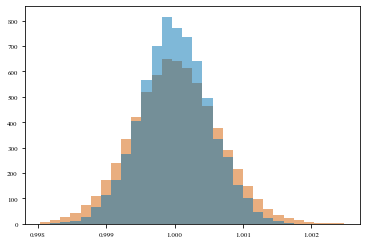

In [7]:
ax = plt.axes()
plot_hists(ax,ts_kep['flux'],ts_tess['flux'])

In [8]:
np.concatenate((ts_kep['flux'],ts_tess['flux']))

array([1.00033987, 1.00041256, 1.0005839 , ..., 1.00015628, 1.00027168,
       1.00021446])

In [9]:
white, mask = lc.flatten().remove_outliers(return_mask=True)

In [10]:
mask

array([False, False, False, ..., False, False, False])

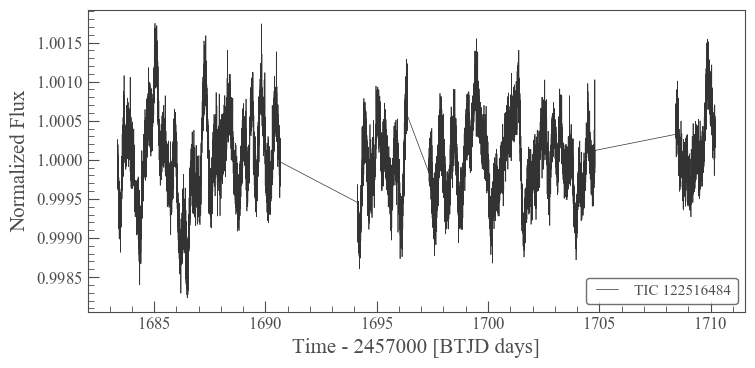

In [11]:
lc[~mask].plot()

In [12]:
timerange = lc.time.max()-lc.time.min()

In [13]:
t0 = np.nanmedian(ts_kep['time'])

In [14]:
times = (ts_kep['time']>t0)*(ts_kep['time']<(t0+timerange))

In [15]:
ts_kep[times]

time,flux,QUARTER
float64,float64,float64
55688.48494151562,1.0003937710109612,9.0
55688.50537613441,1.0001752011279201,9.0
55688.52581085311,1.0006177930535476,9.0
55688.546245371705,1.000454287930407,9.0
55688.56668009023,1.0007454430993639,9.0
55688.587114708665,1.0003813474327516,9.0
55688.607549327,1.0006434836063407,9.0
55688.62798394525,1.0003118843564165,9.0
55688.6484185634,1.0010111911415907,9.0


In [16]:
plot_all(ts_kep,ts_tess,save_file='plots_%d.png' % kic,
         formal_name='%s (KIC %d)' %  (name.replace('_',' '),kic))


TypeError: plot_all() missing 2 required positional arguments: 'even' and 'meta'

In [ ]:
np.sum(kepler['QUARTER'] % 2 ==0)

In [ ]:
meta = {'Name':name,
        'KIC':kic,
        'TIC':tic,
        'Kepmag':5}


In [ ]:
for key, val in meta.items():
    print(key,val)

In [ ]:
from seaborn import despine
from matplotlib.pyplot import figure, subplots, subplot, setp

def plot_info(ax, meta):
    vals = []
    keys = []
    for key,val in meta.items():
        keys.append(key+'\n')
        vals.append(str(val).replace('_',' ')+'\n')
    ax.text(0.0,0.83, ''.join(keys), size=20, va='top')
    ax.text(0.97,0.83,''.join(vals), size=20, va='top', ha='right')
    despine(ax=ax, left=True, bottom=True)
    setp(ax, xticks=[], yticks=[])


In [ ]:
ax = plt.axes()
plot_info(ax,meta)

In [ ]:
    text = []
    for key,val in meta.items():
        text.append(key+' '+str(val)+'\n')


In [ ]:
''.join(text)

In [ ]:
key.swapcase()